### Inverse Modelling: Demonstration of parameterisation of structure and history matching
#### Showcasing LoopStructural-Flopy to address Model Structure Uncertainty

This notebook uses a simple example to show how the pinchout of a formation at an unconformity can be included in uncertainty analysis using parameterisation and estimation of parameters and forecasting.


## Processing MCMC

In [1]:
import pandas as pd
import numpy as np
import subprocess
import sys
import os
import pickle
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
import functions
#%run ./loop_showcase_functions.ipynb  # Contains project specific functions
    
sys.path.append('../../MODFLOW_Tools')    
logfunc = lambda e: np.log10(e)

#### Load Reference Results

In [2]:
#results_folder = '../results_for_paper/'
results_folder = '../results/'

pickleoff = open(results_folder + 'times.pkl','rb')
times = pickle.load(pickleoff)
pickleoff.close()

pickleoff = open(results_folder + 'reference.pkl','rb')
hk_ref, vk_ref, ss_ref, sy_ref = pickle.load(pickleoff)
pickleoff.close()
cp_ref = -100

# Get reference results
pickleoff = open(results_folder + 'ref_past.pkl','rb')
ref_past = pickle.load(pickleoff)
pickleoff.close()
ref_past = np.array(ref_past)

pickleoff = open(results_folder + 'ref_future.pkl','rb')
ref_future = pickle.load(pickleoff)
pickleoff.close()
ref_future = np.array(ref_future)

ref_results = np.append(ref_past, ref_future, axis=2)

In [3]:
print('\nHk Reference')
for i in hk_ref: print(logfunc(i))
print('\nVk Reference')
for i in vk_ref: print(logfunc(i))
print('\nSs Reference')
for i in ss_ref: print(logfunc(i))
print('\nSy Reference')
print(sy_ref)
print('\nCPz Reference')
print(cp_ref)


Hk Reference
0.2304489213782739
-1.154901959985743
0.9138138523837167
-1.3010299956639813

Vk Reference
-0.9208187539523752
-2.154901959985743
-0.2924298239020636
-2.3010299956639813

Ss Reference
-4.045757490560675
-4.154901959985743
-4.698970004336019
-4.096910013008056

Sy Reference
[0.12, 0.1, 0.1, 0.1]

CPz Reference
-100


#### Load MCMC Results

In [4]:
# Load DREAM results
pickleoff = open(results_folder + 'dream_pars_chain_0_.pkl','rb') # dream_pars (122, 13)
dream_pars_0 = pickle.load(pickleoff)
pickleoff.close()

pickleoff = open(results_folder + 'dream_pars_chain_1_.pkl','rb') # dream_pars (122, 13)
dream_pars_1 = pickle.load(pickleoff)
pickleoff.close()

pickleoff = open(results_folder + 'dream_pars_chain_2_.pkl','rb') # dream_pars (122, 13)
dream_pars_2 = pickle.load(pickleoff)
pickleoff.close()

pickleoff = open(results_folder + 'dream_pars_chain_3_.pkl','rb') # dream_pars (122, 13)
dream_pars_3 = pickle.load(pickleoff)
pickleoff.close()

pickleoff = open(results_folder + 'dream_pars_chain_4_.pkl','rb') # dream_pars (122, 13)
dream_pars_4 = pickle.load(pickleoff)
pickleoff.close()

dream_pars = [dream_pars_0, dream_pars_1, dream_pars_2, dream_pars_3, dream_pars_4]
dream_pars = np.array(dream_pars) 

pickleoff = open(results_folder + 'dream_results.pkl','rb') # dream_results (105, 5, 3, 42)
dream_results = pickle.load(pickleoff)
pickleoff.close()
dream_results = np.array(dream_results)

# Load MCMC settings
pickleoff = open(results_folder + 'MCMC.pkl','rb') # Load saved observations for future
Min, Mean, Max, nchains, npars, nburn = pickle.load(pickleoff)
pickleoff.close()

# number of ACCEPTED parameter set past/future results, nobs_xy, nobs_z, nts
print('dream_pars shape ', dream_pars.shape)
print('dream_results shape', dream_results.shape)   
print('ref_results shape', ref_results.shape) 

dream_pars shape  (5, 1504, 13)
dream_results shape (7015, 5, 3, 42)
ref_results shape (5, 3, 42)


#### Burn Samples override

In [5]:
nruns = dream_pars.shape[1]
nburn = int(nruns/2)+1 # Override original burns based on convergence graphs
nsamples = dream_pars.shape[1] - nburn
print('number of runs per chain = ', nruns)
print('number of burn per chain = ', nburn, ' TOTAL BURN = ', nchains * nburn)
print('number of samples per chain = ', nsamples, 'TOTAL SAMPLES = ', nchains * nsamples)

number of runs per chain =  1504
number of burn per chain =  753  TOTAL BURN =  3765
number of samples per chain =  751 TOTAL SAMPLES =  3755


#### R values

Final R values: 

Hk1   1.2484338007087872
Hk2   1.0227214880454871
Hk3   1.030521748113519
Hk4   1.1991617218096378
Vk1   1.023546658216828
Vk2   1.0071725910282807
Vk3   1.025653212037948
Vk4   1.1585118316799796
Ss2   1.0422743958014653
Ss3   1.026969591303457
Ss4   1.0031733329059658
Sy1   1.0186087800480945
CP1   1.009241582968632


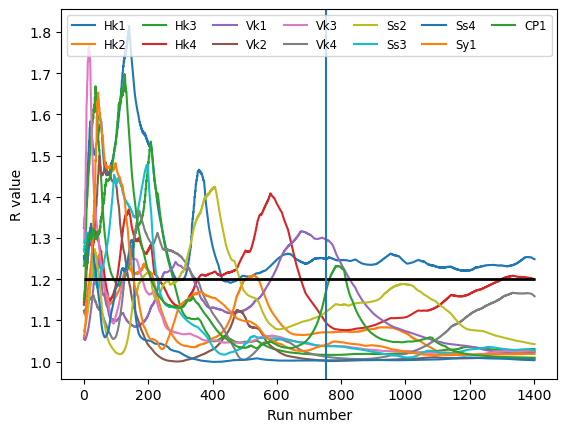

In [6]:
labels = ['Hk1', 'Hk2', 'Hk3', 'Hk4', 'Vk1', 'Vk2', 'Vk3', 'Vk4', 'Ss2', 'Ss3', 'Ss4', 'Sy1', 'CP1']

pickleoff = open(results_folder + 'R_values.pkl','rb')
R = pickle.load(pickleoff)
pickleoff.close()
Rall = list(zip(*R))
for i in range(len(Rall)):
    plt.plot(Rall[i])
plt.ylabel('R value')
plt.xlabel('Run number')
plt.legend(labels = labels , fontsize = 'small', loc = 'upper center', ncols = 7, mode = 'expand', )
plt.hlines(y = 1.2, xmin = 0, xmax = len(Rall[0]), color = 'black', lw = 2)
plt.axvline(nburn)

print("Final R values: \n")
for i, n in enumerate(R[-1]):
    print(labels[i], ' ', R[-1][i])

#### Look at MCMC chain convergence

(-250.0, 0.0)

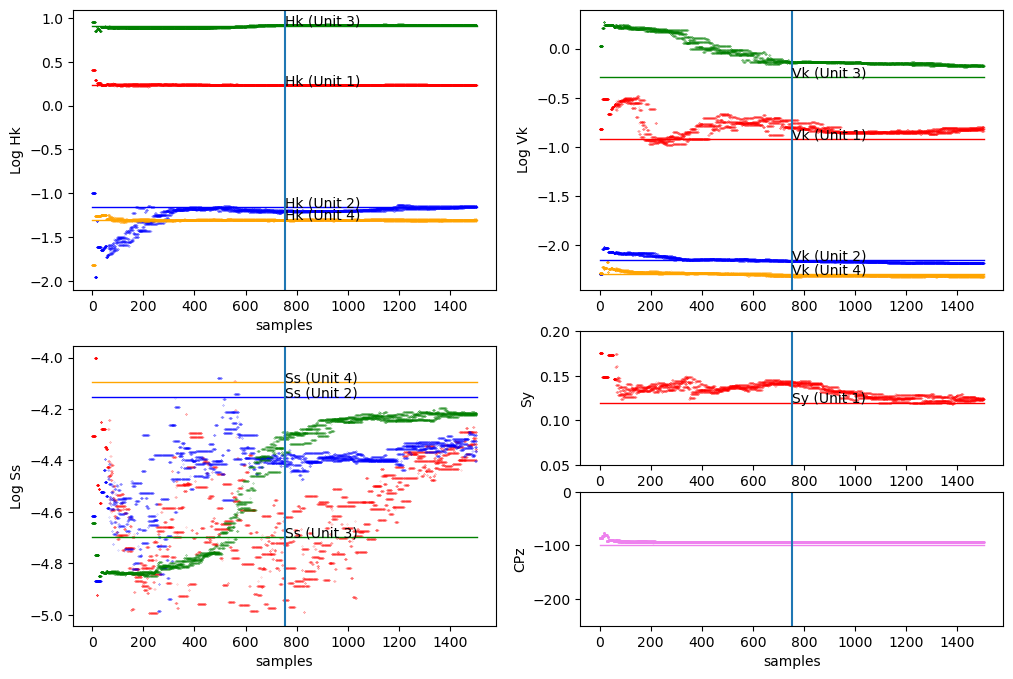

In [7]:
colors = ['red', 'blue','green', 'orange']

plt.style.use('default')
fig = plt.figure(figsize=(12,8))
ax = plt.subplot(2,2,1)
for i in range(4):
    for j in range(nchains):
        plt.plot(dream_pars[j,:,i], 'o', color = colors[i], ms=0.2, alpha = 0.5)
for n, i in enumerate(hk_ref): 
    plt.plot((0, nburn+nsamples),(logfunc(i), logfunc(i)), color = colors[n], lw = 1)
    ax.annotate(f'Hk (Unit {n+1})', (nburn, logfunc(i)), c='black', size = 10)
plt.xlabel('samples')
plt.ylabel('Log Hk')
plt.axvline(nburn)

ax = plt.subplot(2,2,2)
for i in range(4,8):
    for j in range(nchains):
        plt.plot(dream_pars[j,:,i], 'o', color = colors[i-4], ms=0.2, alpha = 0.5)
for n, i in enumerate(vk_ref): 
    plt.plot((0, nburn+nsamples),(logfunc(i), logfunc(i)), color = colors[n], lw = 1)
    ax.annotate(f'Vk (Unit {n+1})', (nburn, logfunc(i)), c='black', size = 10)
plt.xlabel('samples')
plt.ylabel('Log Vk')
plt.axvline(nburn)
plt.xlabel(' ')

ax = plt.subplot(2,2,3)
for i in range(8,11):
    for j in range(nchains):
        plt.plot(dream_pars[j,:,i], 'o', color = colors[i-8], ms=0.2, alpha = 0.5)
for n, i in enumerate(ss_ref[1:]): 
    plt.plot((0, nburn+nsamples),(logfunc(i), logfunc(i)), color = colors[n+1], lw = 1)
    ax.annotate(f'Ss (Unit {n+2})', (nburn, logfunc(i)), c='black', size = 10)
#plt.legend(['Chain 0', 'Chain 1', 'Chain 2', 'Chain 3', 'Chain 4'])
plt.xlabel('samples')
plt.ylabel('Log Ss')
plt.axvline(nburn)
#plt.title('Ss convergence')

ax = plt.subplot(4,2,6)
for j in range(nchains):
    plt.plot(dream_pars[j,:,11], 'o', color = colors[0], ms=0.2, alpha = 0.5)
plt.plot((0, nburn+nsamples),(sy_ref[0], sy_ref[0]), color = colors[0], lw = 1)
ax.annotate('Sy (Unit 1)', (nburn, sy_ref[0]), c='black', size = 10)
plt.xlabel('samples')
plt.ylabel('Sy')
plt.axvline(nburn)
#plt.title('Sy convergence')
plt.ylim([0.05,0.2])

ax = plt.subplot(4,2,8)
for j in range(nchains):
    plt.plot(dream_pars[j,:,12], 'o', color = 'violet', ms=0.6, alpha = 0.5)
plt.plot((0, nburn+nsamples),(cp_ref, cp_ref), color = 'violet', lw = 1)
#plt.legend(['Chain 0', 'Chain 1', 'Chain 2', 'Chain 3', 'Chain 4'])
plt.xlabel('samples')
plt.ylabel('CPz')
plt.axvline(nburn)
#plt.title('CPz convergence')
plt.ylim([-250, 0])

In [8]:
print(dream_pars[:,-800:,0].flatten().mean()) # Mean of hk1 for last 800 runs
print(10**dream_pars[:,-800:,0].flatten().mean()) # Linear mean of hk1 for last 800 runs
print(dream_pars[:,-800:,0].flatten().std()) # Std of hk1 for last 800 runs

0.2376119923818565
1.7282715958834807
0.0019450676593819414


### Plot parameter estimates

In [9]:
# Gaussian kernel desnsity estimation
from scipy import stats
x_pts, data, estimated_pdfs = [], [], []
for n in range(npars):
    d = dream_pars[:, nburn:, n].flatten()
    x = np.linspace(Min[n], Max[n], 200)
    gkde_obj = stats.gaussian_kde(d)
    
    data.append(d)
    x_pts.append(x)
    estimated_pdfs.append(gkde_obj.evaluate(x))

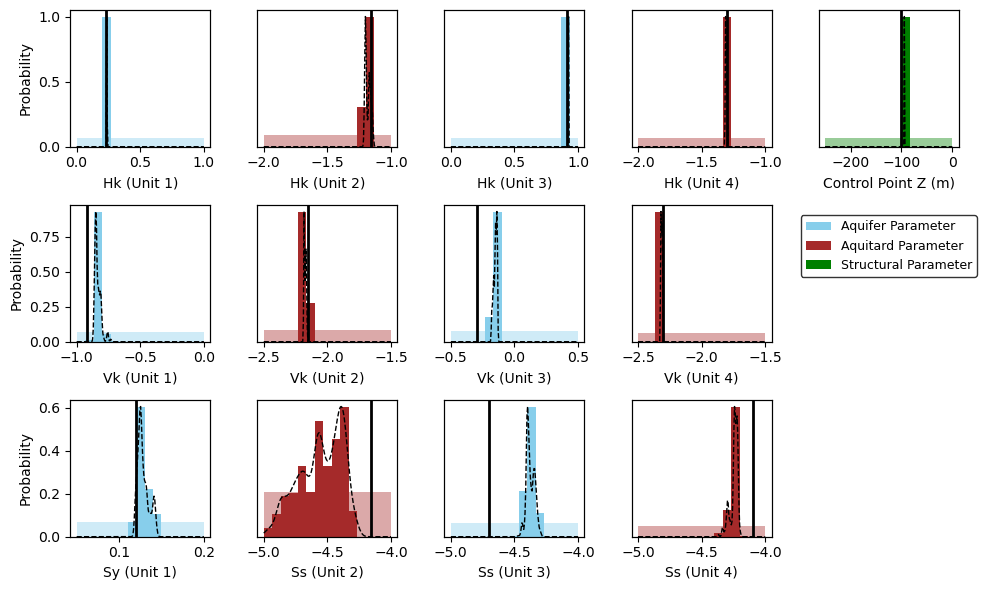

In [19]:
bins = 15

plt.style.use('default')
from matplotlib.ticker import AutoMinorLocator
fig, ax = plt.subplots(3,5, figsize = (10,6))

# Hk
for i in range(4):
    n = i # parameter number
    ax = plt.subplot(3,5,i+1)
    ax2 = ax.twinx()
    if i == 0 or i ==2: 
        ax2.plot(x_pts[n], estimated_pdfs[n], color = 'black', ls = '--', lw = 1)
        ax.hist(data[n], bins=bins, range = (Min[n],Max[n]), color = 'skyblue', weights=1/len(data[n]) * np.ones(len(data[n])))
        prior = np.linspace(Min[n],Max[n],bins+1, endpoint = False)[1:]
        ax.hist(prior, bins=bins, range = (Min[n],Max[n]), color = 'skyblue', alpha = 0.4, weights=1/len(prior) * np.ones(len(prior)))
    if i ==1 or i ==3: 
        ax2.plot(x_pts[n], estimated_pdfs[n], color = 'black', ls = '--', lw = 1)
        ax.hist(data[n], bins=bins, range = (Min[n],Max[n]), color = 'brown', weights=1/len(data[n]) * np.ones(len(data[n])))
        prior = np.linspace(Min[n],Max[n],bins+1, endpoint = False)[1:]
        ax.hist(prior, bins=bins, range = (Min[n],Max[n]), color = 'brown', alpha = 0.4, weights=1/len(prior) * np.ones(len(prior)))
    plt.axvline(logfunc(hk_ref[i]), color = 'black', lw = 2)
    ax.set_xlabel(f'Hk (Unit {i+1})')
    if i == 0: ax.set_ylabel('Probability')
    #ax.set_ylim([0,500])
    #ax.set_xlim([Min[n], Max[n]])
    if i != 0: ax.set_yticks([])
    ax2.set_yticks([])
    ax2.set_ylim(bottom=0, top=None)

# Vk        
for i in range(4):
    n = i+4 # parameter number
    ax = plt.subplot(3,5,i+6)
    ax2 = ax.twinx()
    if i == 0 or i ==2: 
        ax2.plot(x_pts[n], estimated_pdfs[n], color = 'black', ls = '--', lw = 1)
        ax.hist(data[n], bins=bins, range = (Min[n],Max[n]), color = 'skyblue', weights=1/len(data[n]) * np.ones(len(data[n])))
        prior = np.linspace(Min[n],Max[n],bins+1, endpoint = False)[1:]
        ax.hist(prior, bins=bins, range = (Min[n],Max[n]), color = 'skyblue', alpha = 0.4, weights=1/len(prior) * np.ones(len(prior)))
    if i ==1 or i ==3: 
        ax2.plot(x_pts[n], estimated_pdfs[n], color = 'black', ls = '--', lw = 1)
        ax.hist(data[n], bins=bins, range = (Min[n],Max[n]), color = 'brown', weights=1/len(data[n]) * np.ones(len(data[n])))
        prior = np.linspace(Min[n],Max[n],bins+1, endpoint = False)[1:]
        ax.hist(prior, bins=bins, range = (Min[n],Max[n]), color = 'brown', alpha = 0.4, weights=1/len(prior) * np.ones(len(prior)))
    plt.axvline(logfunc(vk_ref[i]), color = 'black', lw = 2)
    ax.set_xlabel(f'Vk (Unit {i+1})')
    if i == 0: ax.set_ylabel('Probability')
    #ax.set_ylim([0,nsamples*5])
    #ax.set_ylim([0,500])
    #ax.set_xlim([Min[n], Max[n]])
    if i != 0: ax.set_yticks([])
    ax2.set_yticks([])
    ax2.set_ylim(bottom=0, top=None)
        
# Sy
n = 11 # parameter number
ax = plt.subplot(3,5,11)
ax2 = ax.twinx()
ax2.plot(x_pts[n], estimated_pdfs[n], color = 'black', ls = '--', lw = 1)
ax.hist(data[n], bins=bins, range = (Min[n],Max[n]), color = 'skyblue', weights=1/len(data[n]) * np.ones(len(data[n])))
prior = np.linspace(Min[n],Max[n],bins+1, endpoint = False)[1:]
ax.hist(prior, bins=bins, range = (Min[n],Max[n]), color = 'skyblue', alpha = 0.4, weights=1/len(prior) * np.ones(len(prior)))
plt.axvline(sy_ref[0], color = 'black', lw = 2)
ax.set_xlabel('Sy (Unit 1)')
ax.set_ylabel('Probability')
#ax.set_ylim([0,nsamples*5])
#ax.set_xlim([Min[n], Max[n]])
#ax.set_ylim([0,500])
ax2.set_yticks([])
ax2.set_ylim(bottom=0, top=None)

#Ss
for i in range(3):
    n = i+8 # parameter number
    ax = plt.subplot(3,5,i+12)
    ax2 = ax.twinx()
    if i == 0 or i == 2: 
        ax2.plot(x_pts[n], estimated_pdfs[n], color = 'black', ls = '--', lw = 1)
        ax.hist(data[n], bins=bins, range = (Min[n],Max[n]), color = 'brown', weights=1/len(data[n]) * np.ones(len(data[n])))
        prior = np.linspace(Min[n],Max[n],bins+1, endpoint = False)[1:]
        ax.hist(prior, bins=bins, range = (Min[n],Max[n]), color = 'brown', alpha = 0.4, weights=1/len(prior) * np.ones(len(prior)))
    if i == 1: 
        ax2.plot(x_pts[n], estimated_pdfs[n], color = 'black', ls = '--', lw = 1)
        ax.hist(data[n], bins=bins, range = (Min[n],Max[n]), color = 'skyblue', weights=1/len(data[n]) * np.ones(len(data[n])))
        prior = np.linspace(Min[n],Max[n],bins+1, endpoint = False)[1:]
        ax.hist(prior, bins=bins, range = (Min[n],Max[n]), color = 'skyblue', alpha = 0.4, weights=1/len(prior) * np.ones(len(prior)))
    plt.axvline(logfunc(ss_ref[i+1]), color = 'black', lw = 2)
    ax.set_xlabel(f'Ss (Unit {i+2})')
    #ax.set_ylim([0,500])
    #ax.set_xlim([Min[n], Max[n]])
    ax.set_yticks([])
    #ax.set_ylim([0,nsamples*5])
    ax2.set_yticks([])
    ax2.set_ylim(bottom=0, top=None)

# CPz   
n = 12 
ax = plt.subplot(3,5,5)    
ax2 = ax.twinx()
ax2.plot(x_pts[n], estimated_pdfs[n], color = 'black', ls = '--', lw = 1)
ax.hist(data[n], bins=bins, range = (Min[n],Max[n]), color = 'green', weights=1/len(data[n]) * np.ones(len(data[n])))
prior = np.linspace(Min[n],Max[n],bins+1, endpoint = False)[1:]
ax.hist(prior, bins=bins, range = (Min[n],Max[n]), color = 'green', alpha = 0.4, weights=1/len(prior) * np.ones(len(prior)))
plt.axvline(cp_ref, color = 'black', lw = 2)
ax.set_xlabel('Control Point Z (m)')
#ax.set_ylabel('Frequency')
#ax.set_xlim([Min[n], Max[n]])
#ax.set_ylim([0,nsamples*5])
ax.set_yticks([])
ax2.set_yticks([])
ax2.set_ylim(bottom=0, top=None)

ax = plt.subplot(3,5,10) 
ax.set_axis_off()


import matplotlib.patches as mpatches
A = mpatches.Patch(facecolor = 'skyblue', edgecolor='none', label='Aquifer Parameter')
B = mpatches.Patch(facecolor = 'brown', edgecolor='none', label='Aquitard Parameter')
C = mpatches.Patch(facecolor = 'green', edgecolor='none', label='Structural Parameter')
ax.legend(handles=[A, B, C], loc="center", fontsize = 9, ncols = 1, edgecolor = 'black',
          bbox_to_anchor=[0.5, 0.7])#, title = 'Probability Contours of Injection Zone (Conc > 5mg/L)')

ax = plt.subplot(3,5,15) 
ax.set_axis_off()

#plt.subplots_adjust(wspace=0.5)#, hspace=0.1)    
plt.tight_layout()  
fig.savefig('../figures/fig9', dpi=450) 

In [11]:
import math
print('\nCP mean ', np.average(data[12]))
print('CPl std ', np.std(data[12]))


CP mean  -94.06158528967147
CPl std  0.2236690184460215


### Compare predictions against reality

In [12]:
dream_results_0 = np.nanpercentile(dream_results, 0, axis=0)      # Find stacked minimum
dream_results_100 = np.nanpercentile(dream_results, 100, axis=0)  # Find stacked maximum

dream_results_0.shape

(5, 3, 42)

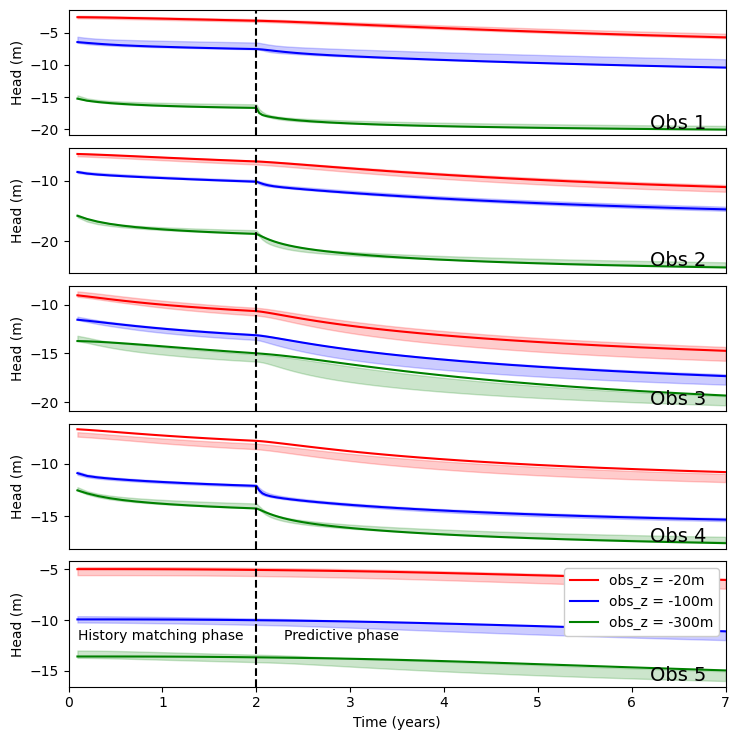

In [34]:
dream_results_0 = np.nanpercentile(dream_results, 0, axis=0)      # Find stacked minimum
dream_results_100 = np.nanpercentile(dream_results, 100, axis=0)  # Find stacked maximum

plt.style.use('default')
fig = plt.figure(figsize=(7.5,7.5))
colors = ['red', 'blue','green']
labels = ['obs_z = -20m', 'obs_z = -100m', 'obs_z = -300m']  
for j in range(5):  # OBS in xy
    ax = plt.subplot(5, 1, j+1,aspect='auto')
    #ax.set_title('Obs %i' %(j))
    ax.annotate('Obs %i' %(j+1), (6.2, np.min(dream_results_0[j].flatten())), c='black', size = 14) #, weight = 'bold')    
    for k in range(3): # OBS in z
        ax.fill_between(times, dream_results_0[j, k], dream_results_100[j, k], color = colors[k], alpha = 0.2)        
        ax.plot(times, ref_results[j, k], lw = 1.5, label = labels[k], color = colors[k])
    if j == 4: ax.set_xlabel('Time (years)', size = 10)
    if j < 4: ax.set_xticks([])

    ax.set_ylabel('Head (m)', size = 10)
    ax.axvline(2, color = 'black', ls = '--')
    if j ==4: ax.annotate('History matching phase', (0.1,-12), c='black', size = 10) #, weight = 'bold')   
    if j ==4: ax.annotate('Predictive phase', (2.3,-12), c='black', size = 10) #, weight = 'bold')   
    ax.set_xlim([0,7])
    #ax.set_ylim([-20,0])
    if j ==4: ax.legend(loc = 'upper right', framealpha = 1.0, facecolor="white")
    
plt.tight_layout()    
plt.subplots_adjust(hspace=0.1)
plt.show()
fig.savefig('../figures/fig10', dpi=450) 

### Examine run times

In [14]:
pickleoff = open(results_folder + 'run_times.pkl','rb')
geo_model_runtime, flow_model_runtime = pickle.load(pickleoff)
pickleoff.close()

print(len(geo_model_runtime))

print('\nGeo model mean ', np.average(geo_model_runtime))
print('Geo model std ', np.std(geo_model_runtime))

print('\nFlow model mean ', np.average(flow_model_runtime))
print('Flow model std ', np.std(flow_model_runtime))

7533

Geo model mean  4.125615251958052
Geo model std  1.5734363319462374

Flow model mean  40.909521409796895
Flow model std  53.1220532712671


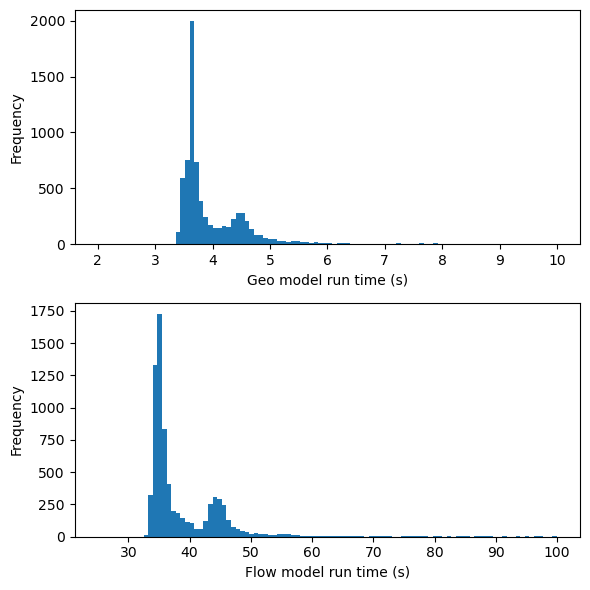

In [33]:
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(211)    
ax.hist(geo_model_runtime, bins=100, range = (2, 10))
ax.set_xlabel('Geo model run time (s)')
ax.set_ylabel('Frequency')
ax = plt.subplot(212)    
ax.hist(flow_model_runtime, bins=100, range = (25, 100))
ax.set_xlabel('Flow model run time (s)')
ax.set_ylabel('Frequency')
plt.tight_layout()    
plt.show()

### Parameter correlation

In [15]:
def Pearson_correlation(X,Y):
    if len(X)==len(Y):
        Sum_xy = sum((X-X.mean())*(Y-Y.mean()))
        Sum_x_squared = sum((X-X.mean())**2)
        Sum_y_squared = sum((Y-Y.mean())**2)       
        corr = Sum_xy / np.sqrt(Sum_x_squared * Sum_y_squared)
    return corr

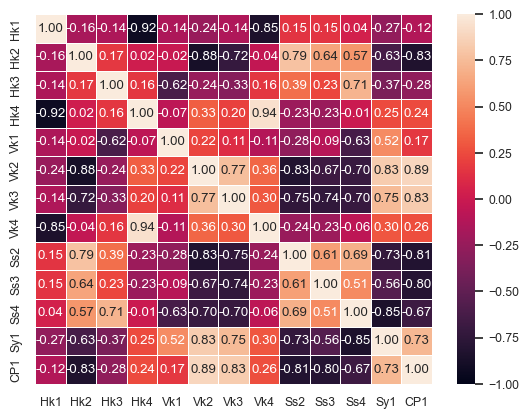

In [16]:
import seaborn as sns

parameters = []
for n in range(npars):
    parameters.append(dream_pars[:, nburn:, n].flatten())

df = pd.DataFrame(parameters)
df = df.T
corr = df.corr(method = 'pearson')

labels = ['Hk1', 'Hk2', 'Hk3', 'Hk4', 'Vk1', 'Vk2', 'Vk3', 'Vk4', 'Ss2', 'Ss3', 'Ss4', 'Sy1', 'CP1']  
#plt.figure(figsize=(3,2), dpi =500)
sns.set(font_scale=0.8)
sns.heatmap(corr, annot=True, fmt=".2f", linewidth=.5, vmin = -1, vmax = 1, xticklabels = labels, yticklabels = labels)
plt.show()

In [17]:
corr[corr!=1.].max()

0     0.154873
1     0.787024
2     0.713173
3     0.941142
4     0.519595
5     0.886592
6     0.831905
7     0.941142
8     0.787024
9     0.639517
10    0.713173
11    0.828420
12    0.886592
dtype: float64

In [18]:
corr[corr!=1.].min()

0    -0.922302
1    -0.876172
2    -0.616819
3    -0.922302
4    -0.629691
5    -0.876172
6    -0.749916
7    -0.849144
8    -0.827722
9    -0.804630
10   -0.849718
11   -0.849718
12   -0.834918
dtype: float64